<a href="https://colab.research.google.com/github/TehilaC/Expert-Ranking-Algorithm-in-Online-Communities/blob/main/Thesis_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

connect

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


In [ ]:
def get_bowtie_components(graph):
    '''Classifying the nodes of a network into a bow-tie structure.
    Here we follow the definition of a bow-tie as in:
    "Bow-tie Decomposition in Directed Graphs" - Yang et al. IEEE (2011)

    input:  NetworkX directed graph or numpy adjacency matrix
    output: sets of nodes in the specified partitions (following the
            NetworkX input graph node labelling or labelled according to
            the order of the adjacency matrix [0, n-1])
    '''
    import networkx as nx

    # Verify graph input format
    input_formats = [nx.DiGraph, np.ndarray, np.matrix]
    assert type(graph) in input_formats, 'Input should be a NetworkX directed graph or numpy adjacency matrix'
    if type(graph) == nx.classes.digraph.DiGraph:
        G = graph.copy()
    if (type(graph) == np.ndarray) | (type(graph) == np.matrix):
        G = nx.from_numpy_matrix(np.matrix(graph), create_using=nx.DiGraph())

    GT = nx.reverse(G, copy=True)

    strongly_con_comp = list(nx.strongly_connected_components(G))
    strongly_con_comp = max(strongly_con_comp, key=len)

    S = strongly_con_comp

    v_any = list(S)[0]
    DFS_G = set(nx.dfs_tree(G,v_any).nodes())
    DFS_GT = set(nx.dfs_tree(GT,v_any).nodes())
    OUT = DFS_G - S
    IN = DFS_GT - S
    V_rest = set(G.nodes()) - S - OUT - IN

    TUBES = set()
    INTENDRILS = set()
    OUTTENDRILS = set()
    OTHER = set()
    for v in V_rest:
        irv = len(IN & set(nx.dfs_tree(GT,v).nodes())) is not 0
        vro = len(OUT & set(nx.dfs_tree(G,v).nodes())) is not 0
        if irv and vro:
            TUBES.add(v)
        elif irv and not vro:
            INTENDRILS.add(v)
        elif not irv and vro:
            OUTTENDRILS.add(v)
        elif not irv and not vro:
            OTHER.add(v)

    return S, IN, OUT, TUBES, INTENDRILS, OUTTENDRILS, OTHER

<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-3-d96208739d46>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  irv = len(IN & set(nx.dfs_tree(GT,v).nodes())) is not 0
<ipython-input-3-d96208739d46>:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  vro = len(OUT & set(nx.dfs_tree(G,v).nodes())) is not 0


## Enable data table display

In [ ]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

# Bring Data from BigQuery via magics

In [ ]:
%%bigquery answers_df_source --project savvy-night-308317
SELECT *
FROM `savvy-night-308317.StackOverflow_Google_dataset.answers_python` a

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery users_df_source --project savvy-night-308317
SELECT *
FROM `savvy-night-308317.StackOverflow_Google_dataset.users_python` a

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery users_rep_df_source --project savvy-night-308317
SELECT *
FROM  `savvy-night-308317.StackOverflow_Google_dataset.v_python_Reputation` r

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery edge_list_df_source --project savvy-night-308317

select q.owner_user_id q_user, a.owner_user_id a_user,
a.score, a.is_accepted_answer
from `StackOverflow_Google_dataset.questions_python` q
left join `StackOverflow_Google_dataset.answers_python` a
on a.parent_id = q.id

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery question_df_soucre --project savvy-night-308317
SELECT *
FROM `savvy-night-308317.StackOverflow_Google_dataset.questions_python`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery votes_df_source --project savvy-night-308317
select v.*, p.type_post,  p.owner_user_id user_id
from `StackOverflow_Google_dataset.votes` v
inner join `StackOverflow_Google_dataset.v_python_posts_id` p
on v.post_id = p.id
where v.vote_type_id in (1, 2, 3)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
edge_list_df_source['calc_score'] = edge_list_df_source['score'] + edge_list_df_source['is_accepted_answer']

In [ ]:
print( len( edge_list_df_source ) )


3367267


Cleaning

In [ ]:
edge_list_df_source = edge_list_df_source.dropna()

In [ ]:
print( len( edge_list_df_source ) )


3005043


Set df between years

In [ ]:
question_df = question_df_soucre.loc[(question_df_soucre['creation_date'].dt.year >= 2013 )& (question_df_soucre['creation_date'].dt.year<= 2020 )]

In [ ]:
answers_df = answers_df_source[answers_df_source["parent_id"].isin(question_df["id"])]

In [ ]:
all_users = question_df["owner_user_id"].append(answers_df["owner_user_id"]).drop_duplicates()
users_df = users_df_source[users_df_source["id"].isin(all_users)].drop_duplicates()
#users_df= users_df.dropna()

<ipython-input-121-21852e4fb8bc>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_users = question_df["owner_user_id"].append(answers_df["owner_user_id"]).drop_duplicates()


In [ ]:
edge_list_df = pd.merge(answers_df[['parent_id', 'id','owner_user_id' , 'score', 'is_accepted_answer']], question_df[['id','owner_user_id']] , how="left", left_on="parent_id", right_on="id" )

In [ ]:
len(edge_list_df['owner_user_id_x'].append(edge_list_df['owner_user_id_y']).drop_duplicates())

<ipython-input-125-6f7c1a1c6186>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  len(edge_list_df['owner_user_id_x'].append(edge_list_df['owner_user_id_y']).drop_duplicates())


729322

In [ ]:
edge_list_df["calc_score"] = 1+ edge_list_df["score"] + edge_list_df["is_accepted_answer"]
edge_list_df.columns = ['parent_id', 'id_a', 'a_user', 'score', 'is_accepted_answer', 'id_q', 'q_user', 'calc_score']

In [ ]:
votes_df = votes_df_source[votes_df_source["post_id"].isin(question_df["id"].append(answers_df["id"]))]

<ipython-input-20-10c26697bc8c>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  votes_df = votes_df_source[votes_df_source["post_id"].isin(question_df["id"].append(answers_df["id"]))]


In [ ]:
votes_df = votes_df.dropna()
votes_df = votes_df.fillna(0)

In [ ]:
votes_df['AnswerUpVotes'] = np.where( (votes_df.vote_type_id == 2) & (votes_df.type_post == 2 ), 1 ,0 )
votes_df['AnswerDownVotes'] = np.where( (votes_df.vote_type_id == 3) & (votes_df.type_post == 2) , 1 ,0 )
votes_df['AcceptedAnswers'] = np.where( (votes_df.vote_type_id == 1) & (votes_df.type_post == 2) , 1 ,0 )

In [ ]:
votes_df['Rep'] = votes_df['AnswerUpVotes'] * 10 + votes_df['AnswerDownVotes'] * -2 + votes_df['AcceptedAnswers'] * 15

In [ ]:
votes_score = votes_df.groupby("post_id")["Rep"].sum()

In [ ]:
edge_list_df = pd.merge( edge_list_df , votes_score , how="left", left_on="id_a", right_on="post_id" )
edge_list_df['Rep']= edge_list_df['Rep'].fillna(0)

In [ ]:
users_df.head()

,id,display_name,about_me,age,creation_date,last_access_date,location,reputation,up_votes,down_votes,...,profile_image_url,website_url,questions_count,answers_count,up_vote_1,down_vote_1,views_1,score,comments,badges
0,5886444,SKipp,None,None,2016-02-05 04:33:25.900000+00:00,2017-03-11 20:27:26.117000+00:00,"St. Louis, MO, United States",76,1,0,...,https://i.stack.imgur.com/gD5j9.png?s=128&g=1,None,<NA>,2,<NA>,<NA>,<NA>,0,1,None
3,5987369,Daniel Olson,None,None,2016-02-26 17:34:07.373000+00:00,2019-08-01 20:18:26.077000+00:00,"Hanover, NH, United States",23,0,0,...,https://graph.facebook.com/10100667364183626/p...,None,1,<NA>,<NA>,<NA>,<NA>,0,1,None
5,7376908,tbuckley,None,None,2017-01-05 01:17:16.023000+00:00,2020-04-01 11:57:48.857000+00:00,None,3,0,0,...,https://www.gravatar.com/avatar/eee2cce23ac0ac...,None,1,<NA>,<NA>,<NA>,<NA>,0,1,None
6,10165745,user10165745,None,None,2018-08-01 12:23:22.033000+00:00,2019-03-03 18:19:15.533000+00:00,India,25,1,0,...,https://www.gravatar.com/avatar/f84f8ab57841a4...,None,1,<NA>,<NA>,<NA>,<NA>,0,1,None
7,12502982,AndrewSJohnson,None,None,2019-12-09 04:47:17.857000+00:00,2020-02-26 22:49:33.503000+00:00,None,1,0,0,...,https://www.gravatar.com/avatar/75c08eb767d111...,None,1,<NA>,<NA>,<NA>,<NA>,0,1,None


In [ ]:
#edge_list_df["calc_score"] = 1+ edge_list_df["score"] + edge_list_df["is_accepted_answer"]

In [ ]:
print("Num Questions: " , len(question_df) )
print("Num Answers: " , len(answers_df) )
print("Num Users: " , len(users_df) )

Num Questions:  1527727
Num Answers:  2118282
Num Users:  789465


Create Graph

In [ ]:
G=nx.DiGraph()

In [ ]:
# create nodes df - users
nodes_users = edge_list_df['q_user'].append(edge_list_df['a_user'])
nodes_users = nodes_users.dropna()
nodes_users = nodes_users.drop_duplicates()
nodes_1 = nodes_users.to_frame()
nodes_1.columns = ['user_id']
nodes_1 = pd.merge( nodes_1, users_df , how="inner", left_on="user_id", right_on="id" )

<ipython-input-29-acac06747f0e>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_users = edge_list_df['q_user'].append(edge_list_df['a_user'])


In [ ]:
print(len(nodes_1))
nodes_1 =nodes_1.dropna(subset='id')
print(len(nodes_1))
nodes_1[nodes_1['id'].notna()]
print(len(nodes_1))

729321
729321
729321


In [ ]:
G.add_nodes_from(nodes_users)

In [ ]:
# create edges list with weight
edges = edge_list_df[["q_user", "a_user", "Rep"]]
edges.columns = ["q_user", "a_user", "weight"]
edges = edges.dropna()

In [ ]:
edges_l = edges.values.tolist()
G.add_weighted_edges_from(edges_l)

In [ ]:
G.is_directed()

True

In [ ]:
# graph properties:
print("Num Edges of graph: ")
print(G.number_of_edges())
print("Num Nodes of graph: ")
print(G.number_of_nodes())
print("in degree")
print(len(G.in_degree))
print("out degree")
print(len(G.out_degree()))

Num Edges of graph: 
1986098
Num Nodes of graph: 
729322
in degree
729322
out degree
729322


Page Rank

In [ ]:
import networkx as nx
pr=nx.pagerank(G, 0.85 , weight='weight' , max_iter = 1000000  )

In [ ]:
#import networkx as nx
#pr=nx.pagerank(G, 0.85 , max_iter = 10000  )

In [ ]:
d=pd.DataFrame(pr, index=[0])
nodes_id = pd.DataFrame( nodes_users )
nodes_id.reset_index(inplace=True, drop=True)
nodes_id.columns=  ["user_id"]

In [ ]:
nodes_id['pr'] = nodes_id['user_id'].map(pr)
nodes_id['pr_int'] = nodes_id['pr'] * 100000
#nodes_id.sort_values(by=['pr'], ascending=False)

In [ ]:
nodes_id.loc[nodes_id["user_id_x"] == 3732008]

KeyError: ignored

HITS

In [ ]:
edges_df = edges
edges_df.columns = ['source', 'target', 'weight' ]
#GG = nx.from_pandas_edgelist(edges_df, edge_attr='weight')

In [ ]:

#GG =GG.to_directed()
#GG.is_directed()

In [ ]:
hubs, authorities = nx.hits(G, max_iter = 1000000 , normalized = True)
# The in-built hits function returns two dictionaries keyed by nodes
# containing hub scores and authority scores respectively.

In [ ]:
nodes_id['hubs'] = nodes_id['user_id'].map(hubs) .astype(float)
nodes_id['authorities'] = nodes_id['user_id'].map(authorities) .astype(float)

Test Result

In [ ]:
#users['new_answers_score'] =
answers_score = answers_df.groupby("owner_user_id")["score" ,"is_accepted_answer"].sum()
answers_score = pd.merge( answers_score , answers_df.groupby("owner_user_id")["id"].count() , how="left", left_on="owner_user_id", right_on="owner_user_id" )
answers_score.columns = ['score', 'is_accepted_answer', 'answer_count']
answers_score['calc_score'] = answers_score["score"] + answers_score["is_accepted_answer"] #+ answers_score["count"]

<ipython-input-43-23e21962433c>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  answers_score = answers_df.groupby("owner_user_id")["score" ,"is_accepted_answer"].sum()


In [ ]:
#users['new_answers_score'] =
question_score = question_df.groupby("owner_user_id")["score"].sum()
question_score = pd.merge( question_score , question_df.groupby("owner_user_id")["id"].count() , how="left", left_on="owner_user_id", right_on="owner_user_id" )
question_score.columns = ['quest_score', 'quest_count']

In [ ]:
votes_score_user = votes_df.groupby("user_id")["Rep"].sum()
votes_score_user.columns = ['user_id_x', 'Rep']

In [ ]:
votes_score_user

user_id
13          318
56           80
62            0
72           25
86          335
           ... 
20021330     -6
20025355     -2
20045546     10
20050221     -2
20053473     20
Name: Rep, Length: 597733, dtype: int64

In [ ]:
#del users
users = users_df[['id','reputation', 'up_vote_1', 'down_vote_1', 'answers_count', 'questions_count', 'score', 'views_1', 'views', 'up_votes', 'down_votes']]
users = pd.merge( users , answers_score , how="left", left_on="id", right_on="owner_user_id" )
users['calc_score']= users['calc_score'].fillna(0)
users = pd.merge( users , question_score , how="left", left_on="id", right_on="owner_user_id" )
users = pd.merge( users , users_rep_df_source , how="left", left_on="id", right_on="user_id" )
users = pd.merge( users , votes_score_user , how="left", left_on="id", right_on="user_id" )
#users['quest_score']= users['quest_score'].fillna(0)

In [ ]:
nodes_id = pd.merge( nodes_id , users, how="left", left_on="user_id", right_on="id" )

In [ ]:
users = pd.merge( users , question_score , how="left", left_on="id", right_on="owner_user_id" )
users.columns


Index(['id', 'reputation', 'up_vote_1', 'down_vote_1', 'answers_count',
       'questions_count', 'score_x', 'views_1', 'views', 'up_votes_x',
       'down_votes_x', 'score_y', 'is_accepted_answer', 'answer_count',
       'calc_score', 'quest_score_x', 'quest_count_x', 'user_id', 'view_count',
       'score', 'questions_cnt', 'answers_cnt', 'comments_cnt', 'badges_cnt',
       'down_votes_y', 'up_votes_y', 'badges_score', 'questions_score',
       'answers_score', 'comments_score', 'Rep', 'quest_score_y',
       'quest_count_y'],
      dtype='object')

Save results to table

In [ ]:
nodes_id = nodes_id.fillna(0)
nodes_id['rank_pr'] = nodes_id['pr'].rank(pct=True)
nodes_id['rank_auth'] = nodes_id['authorities'].rank(pct=True)
nodes_id['rank_hubs'] = nodes_id['hubs'].rank(pct=True)
nodes_id['rank_rep'] = nodes_id['Rep'].rank(pct=True)
nodes_id['rank_question'] = nodes_id['quest_count'].rank(pct=True)

In [ ]:
nodes_id.head()


,user_id_x,pr,pr_int,hubs,authorities,id,reputation,up_vote_1,down_vote_1,answers_count,...,badges_score,questions_score,answers_score,comments_score,Rep,rank_pr,rank_auth,rank_hubs,rank_rep,rank_question
0,13320952,6.714053e-07,0.067141,5.153524e-11,-0.000000e+00,13320952,15,0,-1,0,...,0,-1,0,0,0.0,0.333757,0.362904,0.627444,0.333100,0.488216
1,8156691,6.714053e-07,0.067141,2.350606e-10,-2.905519e-20,8156691,1,0,-5,0,...,0,-5,0,0,0.0,0.333757,0.192369,0.684979,0.333100,0.753434
2,5711870,6.714053e-07,0.067141,-5.949090e-24,-2.654753e-20,5711870,31,3,0,0,...,0,3,0,0,0.0,0.333757,0.201009,0.012985,0.333100,0.488216
3,8372104,4.438619e-05,4.438619,7.815223e-07,1.401188e-06,8372104,10508,730,-3,249,...,40,76,731,145,5743.0,0.998191,0.989823,0.980668,0.998139,0.997252
4,6703095,6.714053e-07,0.067141,5.461754e-10,8.267706e-20,6703095,33,1,0,1,...,0,1,0,0,0.0,0.333757,0.638590,0.721968,0.333100,0.847246


In [ ]:
from pandas_gbq import to_gbq
## Replace the following with your project ID, DataFrame, and table name
project_id = 'savvy-night-308317'
dataframe = nodes_id
table_name = 'StackOverflow_Google_dataset.Nodes_test'

# Export DataFrame to BigQuery
to_gbq(dataframe, table_name, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 6978.88it/s]


In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau


In [ ]:
nodes_id['calc_score']= nodes_id['Rep']

In [ ]:
rho, p = spearmanr(nodes_id['rank_pr'], nodes_id['rank_rep'].fillna(0))

#print Spearman rank correlation and p-value
print(rho)
print(p)


0.9450104840573861
0.0


In [ ]:
rho, p = spearmanr(nodes_id['pr'], nodes_id['Rep'].fillna(0))
#rho, p = spearmanr(users_rank['pr'], users_rank['Reputation_Per_day'] + users_rank['out_degree'] * (1+users_rank['score_out'])+ users_rank['in_degrees'] * (1+users_rank['score_in']))

#print Spearman rank correlation and p-value
print(rho)
print(p)


0.9450104840573861
0.0


In [ ]:
rho, p = spearmanr(nodes_id['hubs'], nodes_id['calc_score'].fillna(0) )

#print Spearman rank correlation and p-value
print(rho)
print(p)

-0.12215362130774315
0.0


In [ ]:
rho, p = spearmanr(nodes_id['hubs'], nodes_id['quest_score'].fillna(0) )

#print Spearman rank correlation and p-value
print(rho)
print(p)

0.47731362015582496
0.0


In [ ]:
rho, p = spearmanr(nodes_id['authorities'], nodes_id['calc_score'].fillna(0))

#print Spearman rank correlation and p-value
print(rho)
print(p)

0.709735265885753
0.0


In [ ]:

# Calculating Kendall Rank correlation
corr, _ = kendalltau(nodes_id['pr'],  nodes_id['calc_score'].fillna(0))
print('Kendall Rank correlation: %.5f' % corr)

corr, _ = kendalltau(nodes_id['hubs'],  nodes_id['quest_score'].fillna(0))
print('Kendall Rank correlation: %.5f' % corr)

corr, _ = kendalltau(nodes_id['authorities'], nodes_id['calc_score'].fillna(0))
print('Kendall Rank correlation: %.5f' % corr)

Kendall Rank correlation: 0.84719


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Kendall Rank correlation: 0.38185
Kendall Rank correlation: 0.56490


In [ ]:
corr, _ = kendalltau(nodes_id['hubs'],  nodes_id['quest_score'].fillna(0))
print('Kendall Rank correlation: %.5f' % corr)

Kendall Rank correlation: 0.38185


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Degrees

In [ ]:
in_degrees = pd.DataFrame([( node , val) for (node, val) in G.in_degree()])
in_degrees.columns = ["node", "in_degrees"]
#in_degrees.loc[in_degrees["in_degrees"] <= 0]

In [ ]:
out_degrees = pd.DataFrame([( node , val) for (node, val) in G.out_degree()])
out_degrees.columns = ["node", "out_degree"]
#out_degrees.loc[out_degrees["out_degree"] <= 0]

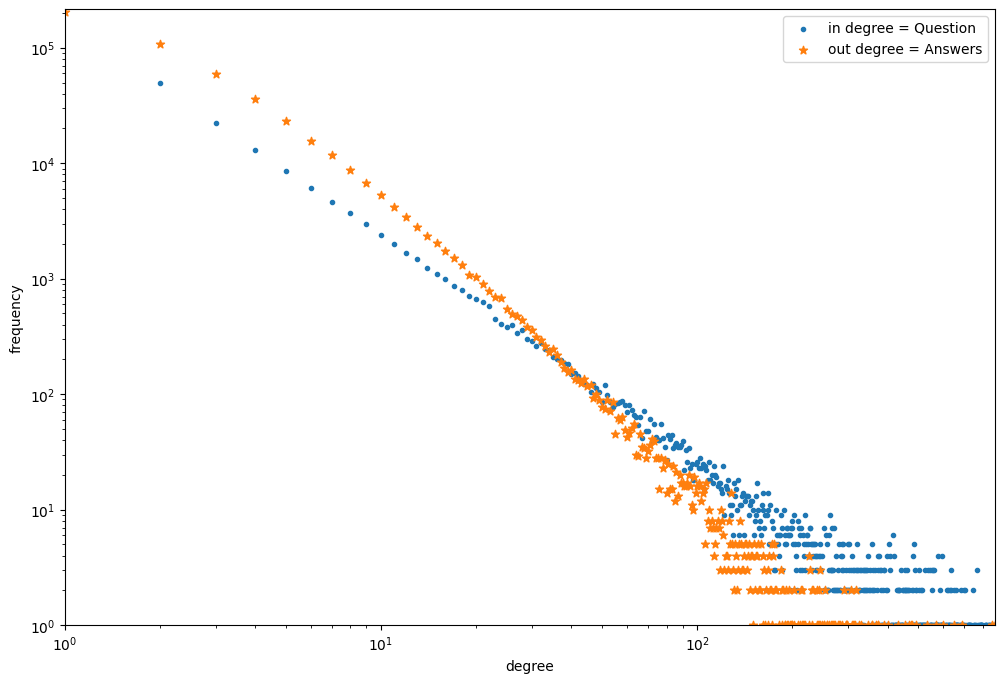

In [ ]:
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt

in_degree_counts = Counter(in_degrees["in_degrees"])
i_x, i_y = zip(*in_degree_counts.items())

plt.figure(figsize=(12, 8))

out_degree_counts = Counter(out_degrees["out_degree"])
o_x, o_y = zip(*out_degree_counts.items())

# prep axes
plt.xlabel('degree')
plt.xscale('log')
plt.xlim(1, max(o_x) )

plt.ylabel('frequency')
plt.yscale('log')
plt.ylim(1, max(o_y))
                                                                                                                                     # do plot
plt.scatter(i_x, i_y, marker='.', label ='in degree = Question')
plt.scatter(o_x, o_y, marker='*', label ='out degree = Answers')
plt.legend()
plt.show()

In [ ]:
nx.degree_pearson_correlation_coefficient(G)

-0.010210817276392194

ValueError: ignored

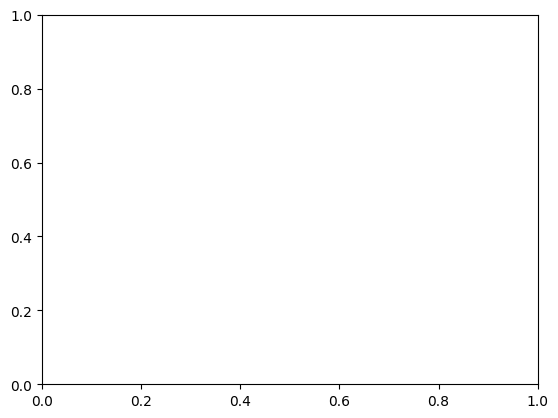

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a random graph (you can replace this with your own graph)

# Calculate degree correlations
degree_correlations = nx.degree_assortativity_coefficient(G)

# Get degree sequence for plotting
degrees = dict(G.degree())
x = [degrees[node] for node in G.nodes()]
y = [degrees[nbr] for node, nbrs in G.adjacency() for nbr in nbrs]

# Plot degree correlations
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Degree of Node')
plt.ylabel('Degree of Neighbor')
plt.title(f'Degree Correlations (Assortativity: {degree_correlations:.2f})')

plt.show()


In [ ]:
# Get degree sequence for plotting
degrees = dict(G.degree())
x, y = zip(*degrees.items())

# Plot degree correlations
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Degree of Node')
plt.ylabel('Degree of Neighbor')
plt.title(f'Degree Correlations (Assortativity: {degree_correlations:.2f})')

plt.show()

In [ ]:
degrees = dict(G.degree())
degree_sequence = [degrees[node] for node in G.nodes()]

# Create a correlation matrix
#correlation_matrix = np.zeros((len(degree_sequence), len(degree_sequence)))

for i in range(len(degree_sequence)):
    for j in range(len(degree_sequence)):
        correlation_matrix[i, j] = abs(degree_sequence[i] - degree_sequence[j])

# Plot heatmap of degree correlations
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Degree Correlations')
plt.title(f'Degree Correlations Heatmap (Assortativity: {degree_correlations:.2f})')
plt.xlabel('Node ID')
plt.ylabel('Node ID')

plt.show()

In [ ]:

# Calculate degree correlations
#degree_correlations = nx.degree_assortativity_coefficient(graph)

# Get the degree sequence for all nodes
degrees = dict(G.degree())
degree_sequence = [degrees[node] for node in G.nodes()]

# Sort the degree sequence in descending order
degree_sequence.sort(reverse=True)

# Plot degree-rank plot
plt.loglog(degree_sequence, marker='o', linestyle='None')
plt.xlabel('Node Rank (Descending)')
plt.ylabel('Degree')
plt.title(f'Degree-Rank Plot (Assortativity: {degree_correlations:.2f})')

plt.show()


In [ ]:
# Plot degree-rank plot
plt.loglog(degree_sequence, marker='.', linestyle='None')
plt.xlabel('Node Rank (Descending)')
plt.ylabel('Degree')
plt.title(f'Degree-Rank Plot (Assortativity: {degree_correlations:.2f})')

plt.show()

In [ ]:
# Visualizing a Pandas Correlation Matrix Using Seaborn
import seaborn as sns

df = pd.DataFrame(in_degrees['in_degrees'])

matrix = df.corr().round(2)
sns.heatmap(matrix, annot=True, vmax=10^3, vmin=-1, center=0, cmap='vlag')
plt.show()

In [ ]:
degree = {node: len(list(G.in_edges(node))) for node in G}

# Print the indegree of each node
for node, ind in indegree.items():
  print(f"Node {node}: indegree={ind}")

# Calculate the indegree and outdegree of each node
indegree = G.in_degree
outdegree = G.out_degree

# Create a dictionary of nodes with their indegree and outdegree
nodes = {}
for node, ind in in_degrees.items():
  nodes[node] = {"indegree": ind, "outdegree": outdegree[node]}

# Create a heatmap of the indegree and outdegree
plt.matshow(nodes)
plt.title("Indegree and Outdegree Heatmap")
plt.show()

In [ ]:
#@title Default title text
#!conda create -n bow_tie python=3.8
#!conda activate bow_tie
#! pip install cobra
#! pip install networkx
#! pip install openpyxl
#! pip install xlrd
#! pip install ipykernel
#! python -m ipykernel install --user --name bow_tie --display-name "bow_tie"

In [ ]:
components = list(nx.weakly_connected_components(G))


In [ ]:
input_component = [node for node in components if "Input" in node]
top_events_component = [node for node in components if "Top Events" in node]
preventive_barriers_component = [node for node in components if "Preventive Barriers" in node]
recovery_barriers_component = [node for node in components if "Recovery Barriers" in node]
mitigation_barriers_component = [node for node in components if "Mitigation Barriers" in node]
detective_barriers_component = [node for node in components if "Detective Barriers" in node]
outcomes_component = [node for node in components if "Outcomes" in node]


In [ ]:


# Calculate the bowtie structure
scc = max(nx.strongly_connected_components(G), key=len)  # Largest strongly connected component
wcc = max(nx.weakly_connected_components(G), key=len)    # Largest weakly connected component

in_edges = G.in_edges(scc)              # In-edges of the SCC
out_edges = G.out_edges(scc)            # Out-edges of the SCC
tendrils = set(G.nodes()).difference(scc).difference(wcc)  # Tendrils
tubes = set(in_edges).difference(scc)   # Tubes
disconnected = set(G.nodes()).difference(wcc)    # Disconnected nodes

print("Bowtie structure:")
print("SCC:", len(scc))
print("In-edges:", len(in_edges))
print("Out-edges:", len(out_edges))
print("Tendrils:", len(tendrils))
print("Tubes:", len(tubes))
print("Disconnected:", len(disconnected))


In [ ]:
S, IN, OUT, TUBES, INTENDRILS, OUTTENDRILS, OTHER = get_bowtie_components(graph=G)


In [ ]:
print("Bowtie structure:")
print(len(nodes_id) )
print("SCC:", len(S), " ", len(S) / (G.number_of_nodes()) )
print("In-edges:", " ", len(IN) ," ",  len(IN) / (G.number_of_nodes()))
print("Out-edges:", " " , len(OUT)," ",  len(OUT)/ (G.number_of_nodes()))
print("Tendrils IN:", " ", len(INTENDRILS) ," ", len(INTENDRILS) / (G.number_of_nodes()))
print("Tendrils OUT:", " ", len(OUTTENDRILS) ," ", len(OUTTENDRILS) / (G.number_of_nodes()))
print("Tendrils:", " ", len(OUTTENDRILS)+len(INTENDRILS) ," ", (len(OUTTENDRILS) +len(INTENDRILS))/ (G.number_of_nodes()))
print("Tubes:", len(TUBES) , " ", len(TUBES)/ (G.number_of_nodes()))
print("Disconnected:",len(OTHER), " ", len(OTHER)/ (G.number_of_nodes()))

Bowtie structure:
729322
SCC: 27137   0.03720853066272511
In-edges:   312681   0.4287283257600895
Out-edges:   63002   0.08638434052448712
Tendrils IN:   135322   0.18554493077131912
Tendrils OUT:   97463   0.13363507476807227
Tendrils:   232785   0.31918000553939135
Tubes: 8525   0.011688938493559772
Disconnected: 85192   0.11680985901974711


In [ ]:
print(OTHER)

{11534340, 11010052, 2883589, 1048586, 5767191, 2097176, 6553624, 17039386, 786455, 6553631, 6815780, 6029353, 6553647, 3932209, 786485, 4980789, 13631543, 4456504, 12845113, 5505080, 15990843, 11534397, 6553663, 3407941, 11010127, 3145810, 85, 5767253, 6553687, 7077977, 92, 1572960, 786528, 1048677, 12845160, 4718696, 4456554, 8126575, 4718707, 7864436, 4980855, 3407992, 9961599, 13631621, 12845199, 15204499, 12058773, 1835157, 3670172, 13107363, 2883748, 10223780, 166, 8126628, 12058794, 13631666, 5505213, 524481, 11010244, 14155973, 6291656, 14155983, 14155985, 12583124, 8913115, 4980960, 786662, 6553831, 12320998, 12058858, 12321002, 4980980, 12321012, 11010294, 7078144, 8388868, 2621701, 1835270, 14156041, 7864588, 4981007, 14156048, 4718870, 8651031, 5505303, 262425, 5767451, 11272479, 2359593, 1573161, 5505324, 4194609, 9699646, 9175359, 6291776, 1048896, 322, 2621765, 12321098, 3408206, 10223950, 342, 5505369, 12058970, 7340379, 2359643, 14156124, 9437540, 7602533, 13369707, 41

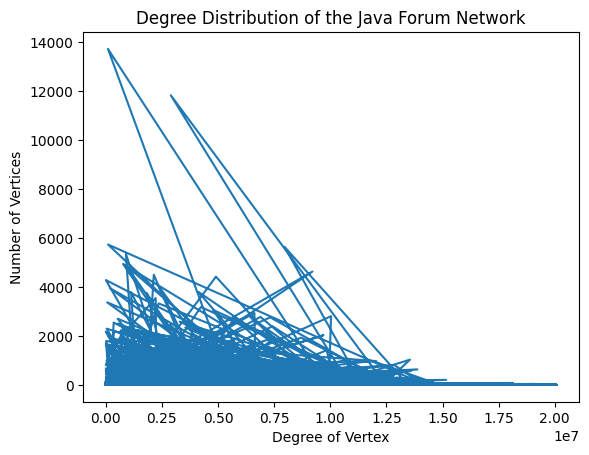

In [ ]:
degrees = dict(G.degree())
x, y = zip(*degrees.items())

# Plot the graph
plt.plot(x, y)

# Add a title and labels
plt.title("Degree Distribution of the Java Forum Network")
plt.xlabel("Degree of Vertex")
plt.ylabel("Number of Vertices")

# Show the graph
plt.show()

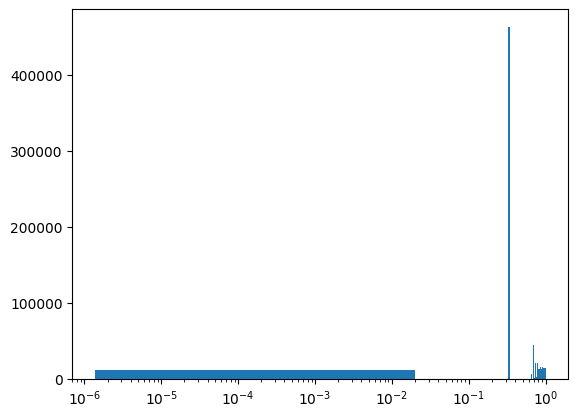

In [ ]:
rep = nodes_id['calc_score'].fillna(0) #.apply(lambda x: np.symlog(x))

#rep.head()
import pylab as pl
import numpy as np

#data = np.random.normal(size=10000)
pl.hist(rep, bins=50)
pl.gca().set_xscale("log")
pl.show()
#authorities[np.isfinite(authorities)].dropna().plot.hist(bins = 15)

In [ ]:
# show hist of ranks
#nodes_id['pr_log'] = nodes_id['pr'].apply(lambda x: np.log(x))
#rep = nodes_id['pr'].apply(lambda x: np.log(x))
nodes_id['pr'].plot.hist( bins = 10, log = True )


KeyError: ignored

<Axes: ylabel='Frequency'>

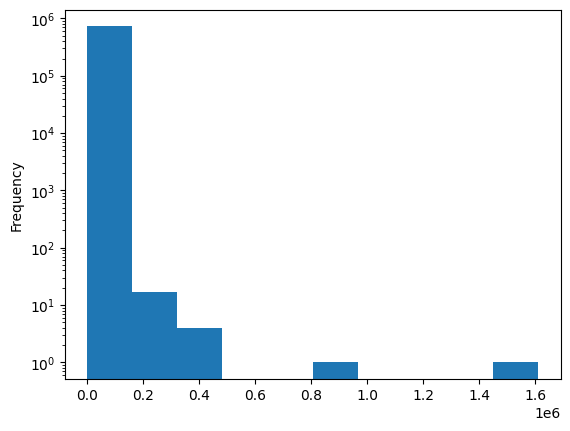

In [ ]:
nodes_id['calc_score'].plot.hist( bins = 10, log = True )

<Axes: ylabel='Frequency'>

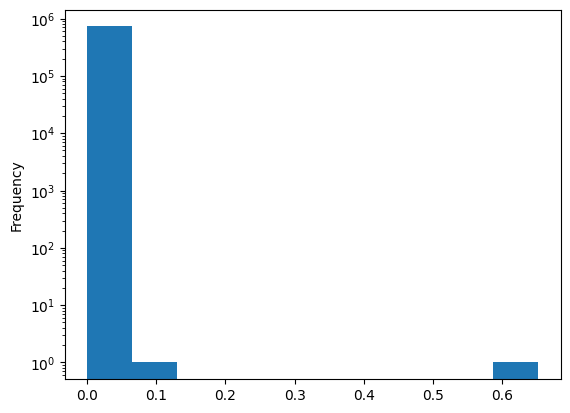

In [ ]:
nodes_id['authorities'].plot.hist( bins = 10, log = True )


In [ ]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
  plt.yscale('log')
plot_loghist(nodes_id['pr'], 10)


<ipython-input-75-abffc294116d>:3: RuntimeWarning: invalid value encountered in log10
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))


Error in callback <function _draw_all_if_interactive at 0x78aa511e0dc0> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 640x480 with 1 Axes>

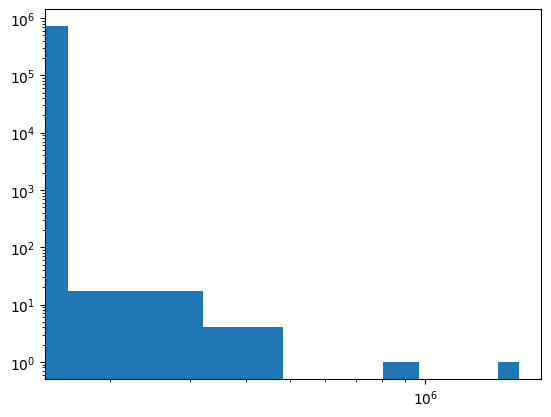

In [ ]:
def plot_symloghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  #logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x)
  plt.xscale('log')
  plt.yscale('log')
#nodes_id['calc_score'].fillna(0)
plot_symloghist(nodes_id['calc_score'].fillna(0), 10)

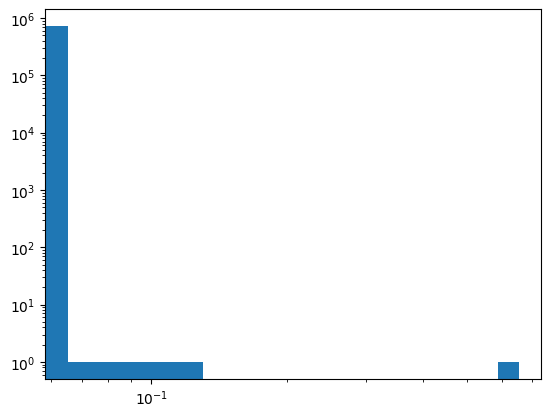

In [ ]:
plot_symloghist(nodes_id['authorities'].fillna(0), 10)

In [ ]:
pl.hist(nodes_id['pr_log'], bins=15)
#pl.gca().set_xscale("log")
pl.show()

KeyError: ignored

In [ ]:
nodes_id['calc_score_rn'] = nodes_id['calc_score'].rank()
nodes_id['pr_rn'] = nodes_id['pr'].rank()
nodes_id['authorities_rn'] = nodes_id['authorities'].rank()
#nodes_id.loc[nodes_id['calc_score'].isna() == True ].head()


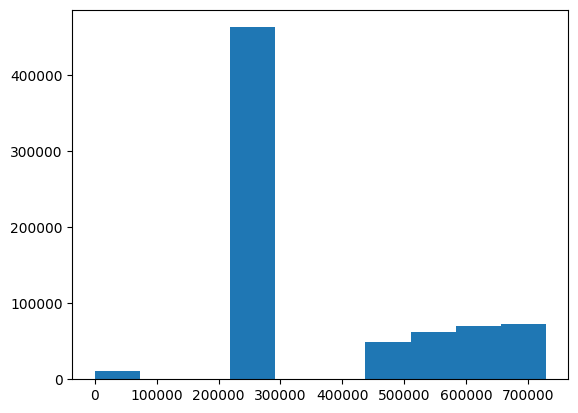

In [ ]:
def plot_symloghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  #logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x)
  #plt.xscale('log')
  #plt.yscale('log')
#nodes_id['calc_score'].fillna(0)
plot_symloghist(nodes_id['calc_score_rn'].fillna(0), 10)

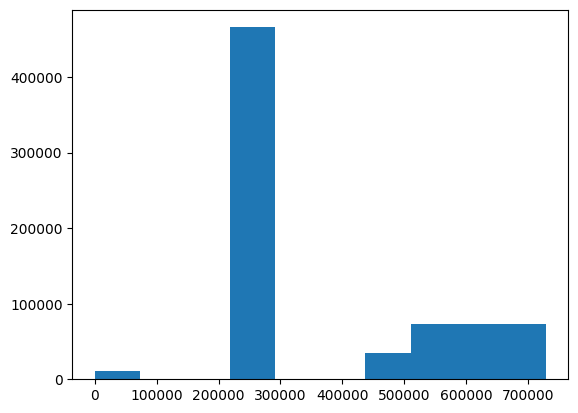

In [ ]:
plot_symloghist(nodes_id['pr_rn'].fillna(0), 10)

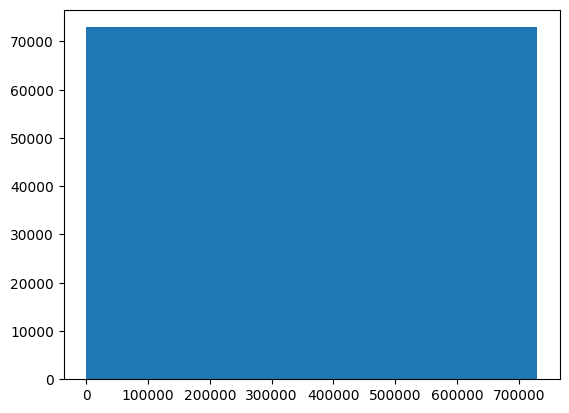

In [ ]:
plot_symloghist(nodes_id['authorities_rn'].fillna(0), 10)

In [ ]:
nodes_id.head()

,user_id_x,pr,pr_int,hubs,authorities,id,reputation,up_vote_1,down_vote_1,answers_count,...,comments_score,Rep,rank_pr,rank_auth,rank_hubs,rank_rep,rank_question,calc_score_rn,pr_rn,authorities_rn
0,13320952,6.714053e-07,0.067141,5.153524e-11,-0.000000e+00,13320952,15,0,-1,0,...,0,0.0,0.333757,0.362904,0.627444,0.333100,0.488216,242937.5,243416.5,264674.0
1,8156691,6.714053e-07,0.067141,2.350606e-10,-2.905519e-20,8156691,1,0,-5,0,...,0,0.0,0.333757,0.192369,0.684979,0.333100,0.753434,242937.5,243416.5,140299.0
2,5711870,6.714053e-07,0.067141,-5.949090e-24,-2.654753e-20,5711870,31,3,0,0,...,0,0.0,0.333757,0.201009,0.012985,0.333100,0.488216,242937.5,243416.5,146600.0
3,8372104,4.438619e-05,4.438619,7.815223e-07,1.401188e-06,8372104,10508,730,-3,249,...,145,5743.0,0.998191,0.989823,0.980668,0.998139,0.997252,727965.0,728003.0,721900.0
4,6703095,6.714053e-07,0.067141,5.461754e-10,8.267706e-20,6703095,33,1,0,1,...,0,0.0,0.333757,0.638590,0.721968,0.333100,0.847246,242937.5,243416.5,465738.0


In [ ]:
full_df = pd.merge( question_df , answers_df, how="left", left_on="id", right_on="parent_id" )


In [ ]:
question_df['date_cr'].sort_values().diff().mean()

Timedelta('0 days 00:02:45.252637477')

In [ ]:
full_df['time_to_answer'] = full_df['creation_date_y'] - full_df['creation_date_x']
#timeAverage(edge_list['time_to_answer'] , avg.time = "hour")
print( "avg time to answer")
print(full_df['time_to_answer'].mean())
#edge_list.dtypes
print( "avg time a")
print( full_df['creation_date_x'].sort_values().diff().mean() )
question_df['date_cr'] = pd.to_datetime(question_df['creation_date'])
print( "avg time q")
print( question_df['date_cr'].sort_values().diff().mean() )
#.agg( {'avg_time_diff' : lambda group: group.sort_values().diff().mean()})
print(full_df.loc[full_df["id_x"]!=full_df["accepted_answer_id_y"]]['time_to_answer'].mean())

avg time to answer
112 days 02:16:26.132998948
avg time a
0 days 00:01:47.959475694
avg time q


<ipython-input-86-3db2bd8678e5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_df['date_cr'] = pd.to_datetime(question_df['creation_date'])


0 days 00:02:45.252637477
112 days 02:16:26.132998948


In [ ]:
answers_first = answers_df.groupby("parent_id")["creation_date"].min()


In [ ]:
question_first_answer = pd.merge( question_df , answers_first, how="left", left_on="id", right_on="parent_id" )


In [ ]:
question_first_answer['time_to_answer'] = question_first_answer['creation_date_y'] - question_first_answer['creation_date_x']
#timeAverage(edge_list['time_to_answer'] , avg.time = "hour")
print( "avg time to answer")
print(question_first_answer['time_to_answer'].mean())
print( "median time to answer")
print(question_first_answer['time_to_answer'].median())
#edge_list.dtypes
print( "avg time a")
print( answers_df['creation_date'].sort_values().diff().mean() )
question_df['date_cr'] = pd.to_datetime(question_df['creation_date'])
print( "avg time q")
print( question_df['creation_date'].sort_values().diff().mean() )
#.agg( {'avg_time_diff' : lambda group: group.sort_values().diff().mean()})
print(full_df.loc[full_df["id_x"]!=full_df["accepted_answer_id_y"]]['time_to_answer'].median())

avg time to answer
20 days 07:55:34.419309201
median time to answer
0 days 00:27:45.600000
avg time a
0 days 00:02:36.814071903
avg time q
0 days 00:02:45.252637477
0 days 00:37:09.503000


<ipython-input-135-b20457e7ab7f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_df['date_cr'] = pd.to_datetime(question_df['creation_date'])


In [ ]:
print(full_df.loc[full_df["id_x"]!=full_df["accepted_answer_id_y"]]['time_to_answer'].median())
print(full_df['creation_date_x'].max())
print(full_df['creation_date_y'].max())

0 days 00:37:09.503000
2020-12-31 23:59:30.313000+00:00
2022-09-25 05:53:35.993000+00:00


In [ ]:
question_first_answer[['id','creation_date_x', 'creation_date_y', 'time_to_answer']].loc[question_first_answer['time_to_answer'].astype('timedelta64[D]')>=350].head()
#np.median(
#full_df['time_to_answer'].median()

,id,creation_date_x,creation_date_y,time_to_answer
96,43847793,2017-05-08 12:32:52.127000+00:00,2019-04-23 11:19:06.667000+00:00,714 days 22:46:14.540000
281,35640364,2016-02-25 23:16:17.980000+00:00,2017-05-12 04:38:06.013000+00:00,441 days 05:21:48.033000
306,42848346,2017-03-17 02:48:06.870000+00:00,2018-04-07 13:56:43.040000+00:00,386 days 11:08:36.170000
313,38418543,2016-07-17 06:28:36.167000+00:00,2020-03-26 16:16:28.743000+00:00,1348 days 09:47:52.576000
439,41920112,2017-01-29 10:57:11.627000+00:00,2020-01-30 01:02:29.693000+00:00,1095 days 14:05:18.066000


In [ ]:
#plt.hist(full_df['time_to_answer'], bins = 10)

#full_df['time_to_answer'].plot.hist( bins = 10, log = True )
#hours = full_df['time_to_answer'].loc[full_df['time_to_answer'].isna()==False].astype('timedelta64[h]')

hours = question_first_answer['time_to_answer'].astype('timedelta64[h]')
hours = hours.dropna()


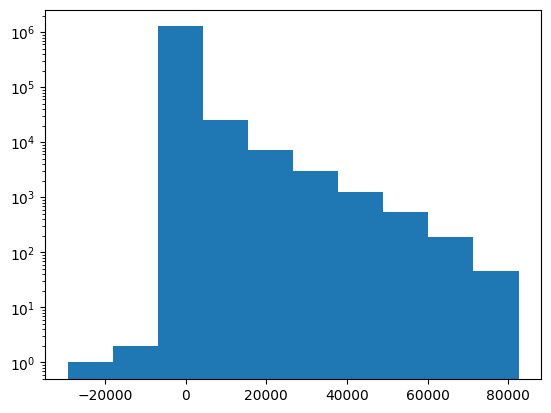

In [ ]:
#hours.plot.hist( bins = 10 )
def plot_symloghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  #logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x)
  #plt.xscale('log')
  plt.yscale('log')
plot_symloghist(hours, 10)


In [ ]:
hours = full_df['time_to_answer'].loc[full_df['is_accepted_answer']==1].astype('timedelta64[D]')


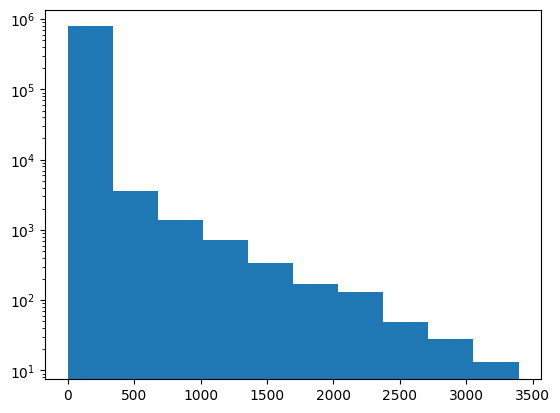

In [ ]:
#hours.plot.hist( bins = 10 )
def plot_symloghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  #logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x)
  #plt.xscale('log')
  plt.yscale('log')
plot_symloghist(hours, 10)


In [ ]:
hubs[np.isfinite(hubs)].dropna().plot.hist(bins = 15)

TypeError: ignored

In [ ]:
# show hist of ranks
#nodes_id['hubs_log'] = nodes_id['hubs'].apply(lambda x: np.log(x))
hubs_df = pd.DataFrame.from_dict(hubs, orient="index", columns=["hubs"])
hubs_df = hubs_df[np.isfinite(hubs_df)].dropna()
plot_symloghist(hubs_df ,10)
